# Projet IOT - MS BGD 2020-2021
## Rémi GENET - Julien MAKSOUD

# SOMMAIRE

[Chargement des librairies](#ChargLib)


[Chargement des fichiers input](#ChargInputFiles)

[Partie I : Création de fonctions](#functionsdef)
* [Fonctions de calcul et display d'erreurs d'estimation de distance](#fonctionsduprof)
* [Fonction de création de training / test set sans feature augmentation](#CreateInputsNoFeatAug)
* [Fonction de création de training / test set avec feature augmentation](#CreateInputsFeatAug)
* [Fonction de test d'algorithmes en masse](#AlgosTestingFunction)




[Partie II: Étude sur les données non-augmentées](#data_basique)
* [Génération du dataset](#data_basique_generation)
* [Testing des algos](#data_basique_test)
* [Synthèse des résultats](#data_basique_summary)


[Partie III: Étude sur les données augmentées](#data_aug)
* [Génération du dataset](#data_aug_generation)
* [Testing des algos](#data_aug_test)
* [Synthèse des résultats](#data_aug_summary)

    
[Partie IV: Comparaison Training Data VS Training Data Augmentée](#comparatiffinal)
* [Comparaison en chiffres](#comp_chiffres)
* [Comparaison graphique](#comp_graph)

[Partie V: Conclusion](#conclusion)

[Partie VI (pour le fun...) : Tentative de réseau de neurones](#funNN)

# Chargement des librairies <a class="anchor" id="ChargLib"></a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from vincenty import vincenty # geopy.distance can also be used
from math import sin, cos, sqrt, atan2, radians
from sklearn.tree import DecisionTreeRegressor

from sklearn.base import is_regressor
import sklearn.ensemble
import sklearn.linear_model
import sklearn.tree
import sklearn.kernel_ridge
import sklearn.neural_network
import sklearn.svm
import sklearn.neighbors
import sklearn.gaussian_process
import sklearn.neural_network
import sklearn.semi_supervised
import sklearn.discriminant_analysis
import sklearn.cross_decomposition
import sklearn.naive_bayes
import sklearn.multioutput
import sklearn.isotonic
import pickle
import copy
import time

# Chargement des inputs <a class="anchor" id="ChargInputFiles"></a>

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

# PARTIE I : Création de fonctions <a class="anchor" id="functionsdef"></a>

## Fonctions de calcul et display d'erreurs d'estimation de distance <a class="anchor" id="fonctionsduprof"></a>

In [3]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]) for m in range(vec_coord.shape[0])]
    return vin_vec_dist


In [4]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## Création d'un dataset pour entraînement sans feature augmentation <a class="anchor" id="CreateInputsNoFeatAug"></a>

In [5]:
def create_dataset_no_feat_augmentation(df_mess_train,df_mess_test,pos_train):
    """ Ce dataframe prend les fichiers input et fait les choses suivantes: 
    1. Ajout du dataframe position aux messagesid associés
    2. Séparation (avec train test split) des datasets d'entrainement et de validation.
    Le train test split est fait en fonction de l'ID du message. 
    Chaque messageid ne représentant pas le même nombre de lignes, pour 2 tirages de train différents, 
    la longueur du dataset train pourra différer.
    3. Générer des numpy arrays (car marche mieux avec les algorithmes utilisés ensuite)
    """
    
    # Ajout du dataframe position aux messages id associés
    pos_train_w_message_number = np.concatenate((df_mess_train['messid'].values.reshape(-1,1),pos_train.values),axis=1)
    pos_train_w_message_number = pd.DataFrame(pos_train_w_message_number, columns=['messid', 'lat','lng'])

    #create message train and test index
    train_id, test_id = train_test_split(df_mess_train['messid'].unique(), test_size=0.2, shuffle=False)
    xtrain = df_mess_train[df_mess_train['messid'].apply(lambda x: x in train_id)]
    xtest = df_mess_train[df_mess_train['messid'].apply(lambda x: x in test_id)]
    ytrain = pos_train_w_message_number[pos_train_w_message_number['messid'].apply(lambda x: x in train_id)]
    ytest = pos_train_w_message_number[pos_train_w_message_number['messid'].apply(lambda x: x in test_id)]

    return xtrain,xtest,ytrain,ytest,pos_train_w_message_number

## Création d'un dataset pour entraînement avec feature augmentation <a class="anchor" id="CreateInputsFeatAug"></a>

Idée: La Feature Augmentation va se faire en deux étapes:

##### create_x_train
        
Lors de la première étape, nous créons une matrice X qui n'utilisera que les messages reçus avec un rssid au dessus d'un certain seuil. 

Puis, pour chaque message, nous allons créer toutes les combinaisons de 3 base stations qui l'ont reçues. 

Si la valeur de seuil de rssi est trop élevée, on tolère de prendre les 5 base stations renvoyant le signal le moins mauvais pour enrichir le dataset.

##### create_x_y_train

On prend les outputs de create_x_train. On créé les y associés à la matrice x et on enlève les messages id de x car ils sont inutiles à la régression


In [6]:

#Create an X matrix by:
    #-Use only message received with a value superior to a threshold
    #-Select for each message all the combination of 3 of the base station that received it
def create_x_train(x, threshold):
    my_list=[]
    #select message one by one
    for messid in x['messid'].unique():
        #create temporary dataframe for this unique message
        tmp=x[x['messid']==messid]
        #create a dataframe filtered for keeping only good rssi
        df_tmp=tmp[tmp['rssi']>threshold]
        #If the filter is to high and do not let enough line, try to increase it progressively to obtain at least 5 lines
        if len(df_tmp)<5:
            df_tmp=tmp[tmp['rssi']>threshold]
            new_threshold=copy.deepcopy(threshold)
            while len(df_tmp)<5 and new_threshold>-200:
                new_threshold-=5
                df_tmp=tmp[tmp['rssi']>new_threshold]
        
        #Check if have at least 3 lines, for some message there is not enought so use the previous function
        #named create_x_test to produce one complete line
        tmp=df_tmp
        if len(tmp)<3:
            tmp=create_x_test(tmp, finalversion=False)
            my_list+=tmp
        #else create all line resulting of the combination of three different line
        #the idea is to have more information per line, as well as producing more line in order to help the model to fit
        else:       
            tmp=tmp.values
            for row_1 in range(len(tmp)):
                for row_2 in range(len(tmp)):
                    for row_3 in range(len(tmp)):
                        if row_1!=row_2 and row_2!=row_3 and row_1!=row_3:
                            my_list.append(list(tmp[row_1,:])+list(tmp[row_2,1:])+list(tmp[row_3,1:]))
    #create a dataframe with the previously created values
    df=pd.DataFrame(my_list,columns=['messid','bsid1','did1','nseq1','rssi1','time_ux1','bs_lat1','bs_lng1','bsid2','did2','nseq2','rssi2','time_ux2','bs_lat2','bs_lng2','bsid3','did3','nseq3','rssi3','time_ux3','bs_lat3','bs_lng3'] )
    #drop useless columns
    df.drop(['time_ux1','nseq1','time_ux2','nseq2','time_ux3','nseq3'], axis=1)
    #Create a column containing the conversion of rssi in Watt (vs dbm)
    df['rssi1W']=df['rssi1'].apply(lambda x: 10**(x/10))
    df['rssi2W']=df['rssi2'].apply(lambda x: 10**(x/10))
    df['rssi3W']=df['rssi3'].apply(lambda x: 10**(x/10))
    return df

#Previously used for xtest, use the available line to create a matrix as for create_x_train
#However is different by making only one line with the 3 best message (according to rssi)
#if less than 3 base station that receive use the best to replace the missing values
def create_x_test(df_mess_test, finalversion=True):
    my_list=[]
    #select message one by one
    for messid in df_mess_test['messid'].unique():
        #select best rssi available for this message
        best_rssi=sorted(df_mess_test[df_mess_test['messid']==messid]['rssi'].values)[::-1]
        #create line, if not enought line in base dataframe then copy the line as many time as needed
        if len(best_rssi)>2:
            part1=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[0]].values
            part2=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[1]].values
            part3=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[2]].values
        elif len(best_rssi)>1:
            part1=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[0]].values
            part2=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[0]].values
            part3=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[1]].values
        else:
            part1=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[0]].values
            part2=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[0]].values
            part3=df_mess_test[df_mess_test['messid']==messid][df_mess_test['rssi']==best_rssi[0]].values

        my_list.append(list(part1[0,:])+list(part2[0,1:])+list(part3[0,1:]))
    #finalversion: used to create x_test like in previous version, not using averaging of predictions for a message
    #if false, then only return my_list, this is used when create_x_train dont have enought line for a message
    if finalversion:
        df=pd.DataFrame(my_list,columns=['messid','bsid1','did1','nseq1','rssi1','time_ux1','bs_lat1','bs_lng1','bsid2','did2','nseq2','rssi2','time_ux2','bs_lat2','bs_lng2','bsid3','did3','nseq3','rssi3','time_ux3','bs_lat3','bs_lng3'] )
        df.drop(['time_ux1','nseq1','time_ux2','nseq2','time_ux3','nseq3'], axis=1)
        df['rssi1W']=df['rssi1'].apply(lambda x: 10**(x/10))
        df['rssi2W']=df['rssi2'].apply(lambda x: 10**(x/10))
        df['rssi3W']=df['rssi3'].apply(lambda x: 10**(x/10))
        return df
    else:
        return my_list

#Create Y associated to X matrix and remove message id from x
def create_x_y_train(pos_train_w_message_number, x_df):
    X=x_df.values
    messids=X[:,0]
    Y=np.zeros((len(X), 2))
    for row in range(len(X)):
        Y[row,0]=pos_train_w_message_number[pos_train_w_message_number['messid']==X[row,0]]['lat'].values[0]
        Y[row,1]=pos_train_w_message_number[pos_train_w_message_number['messid']==X[row,0]]['lng'].values[0]
    X=np.array(list(X[:,1:]), dtype=np.float)
    return X, Y, messids

# #create the train and test features matrix with above functions
# x_train, y_train, messidtrain=create_x_y_train(pos_train_w_message_number,create_x_train(xtrain,-125))
# x_test, y_test, messidtest=create_x_y_train(pos_train_w_message_number,create_x_train(xtest,-115))

<a class="anchor" id="AlgosTestingFunction"></a>
## Création d'une fonction de tests d'algorithmes en batch 

In [21]:
def testingalgos(Xtr,Ytr,Xte,Yte,messidtest):

    """ Cette fonction fait les choses suivantes:  
    1. Elle récupère tous les packages de sklearn
    2. Dans chaque package, elle récupère tous les noms de modèles (algorithmes) existants
    3. Si l'algo est un régresseur (is_regressor(model)==True)
           3.a. Les données sont entrainées avec l'algo
           3.b. Une prédiction sur l'échantillon test/validation est faite
    
    4. Pour chaque message distinct, calcul de la moyenne de la prédiction. 
    Le dataset a été enrichi par duplication de certains messages. Si un message était vu par 10 bornes avec un rssi
    au dessus du seuil désiré, alors le dataset enrichi contient 10! / (7! * 3!) = 120 lignes pour le message unique.
    Il faut donc que les prédictions pour un message donné soient moyennées. Sinon, un même message va servir de nombreuses
    fois pour l'entraînement. Et comme les messages bien captés par de nombreuses base stations vont être sur-représentés,
    ça va faire baisser la distance d'erreur du 80ème percentile. 
    
    
    5. Plot de la courbe de Cumulative Density Function sur l'erreur de prédiction

    6. Ajout du nom de modèle et de la distance du 80ème percentile de la CDF des erreurs de prédiction
           
    7. Sortir un dataframe avec les noms de modèles et les distances d'erreurs de prédiction au 80ème percentile 
    """

    error_dist = []
    model_names = []

    # liste de tous les packages de sklearn
    for package in [sklearn.ensemble,sklearn.linear_model,sklearn.tree,
                    sklearn.svm,sklearn.neighbors,sklearn.gaussian_process,
                    sklearn.semi_supervised,sklearn.discriminant_analysis,
                    sklearn.cross_decomposition,sklearn.naive_bayes,sklearn.multioutput,sklearn.isotonic]:
                
        for modelname in package.__all__:        # On liste tous les modèles de tous les packages
            try:
                model = getattr(package, modelname)()  # Récupère le nom du package
                if is_regressor(model)==True:         # Si l'algo est un classifieur, on essaie de fitter et prédire avec
#                     print(modelname,' is a classifier')
                    try:
                        model = getattr(package, modelname)()  # Récupérer le nom de l'algorithme
                        try: 
                            model.set_params(n_jobs=-1)        # Si possible, utiliser tous les CPU
#                             print(f'n_jobs=-1 for {model}')
                        except:
                            print(f'impossible to set n_jobs=-1 for {model}')
#                               continue

#                         a = time.time()      
                        model.fit(Xtr,Ytr)              
                        print('fit complete')
                        pred=model.predict(Xte)
                        print('predict complete')

                        unique_mess_id_test=np.unique(messidtest)
                        pred2=np.zeros((len(unique_mess_id_test),2))
                        y2=np.zeros((len(unique_mess_id_test),2))
                        counter=0
                        for mess in unique_mess_id_test:
                            nb_val=0
                            avg_pos=np.array([0.0,0.0])
                            for row in range(len(pred)):
                                if messidtest[row]==mess:
                                    ytmp=Yte[row]
                                    avg_pos+=pred[row]
                                    nb_val+=1
                            avg_pos/=nb_val
                            pred2[counter]=avg_pos
                            y2[counter]=ytmp
                            counter+=1

                        err_vec=Eval_geoloc(y2[:,0] , y2[:,1], pred2[:,0], pred2[:,1])

                        values, base = np.histogram(err_vec, bins=50000)
                        cumulative = np.cumsum(values) 
                        plt.figure();
                        plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
                        plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
                        plt.title(f'Error Cumulative Probability for {modelname}'); 
                        plt.legend( [f"Opt LLR | 80% of errors are lower than {round(np.percentile(err_vec, 80),3)} km", "LLR 95", "LLR 99"])
                        plt.show()
#                        print(np.percentile(err_vec, 80))
#                         b = time.time()
#                         print(f"{model} took {round(b-a,3)} seconds to complete")
                        error_dist.append(np.percentile(err_vec, 80))  # ajout du 80th percentile d'erreur du modèle 
                        model_names.append(modelname) 
            
                        del model
                        del pred
#                         print('model and pred deleted')
                    except:
#                         continue 
                        print('Process could not complete for ' , modelname)
            except:
                print('Process could not complete for ' , modelname)
#             continue 
                
    output = pd.DataFrame({'Model': model_names,'DistError': error_dist})  
    
    return output   # retourner le dataframe


# PARTIE II: Étude sur les données non-augmentées <a class="anchor" id="data_basique"></a>

## Création du Dataset <a class="anchor" id="data_basique_generation"></a>

In [38]:
a = time.time()

xtrain,xtest,ytrain,ytest, pos_train_w_message_number = create_dataset_no_feat_augmentation(df_mess_train,df_mess_test,pos_train)
b = time.time()
print(f"Créer des jeux de données sans augmentation de feature a pris {round(b-a,3)} secondes")

Créer des jeux de données sans augmentation de feature a pris 7.096 secondes


In [39]:
#Create Y associated to X matrix and remove message id from x
a = time.time()

xtrain_pa,ytrain_pa,messidtrain_pa = create_x_y_train(pos_train_w_message_number,xtrain)
xtest_pa,ytest_pa,messidtest_pa = create_x_y_train(pos_train_w_message_number,xtest)
b = time.time()
print(f"Créer le Y associé à la matrice X et enlever les messagesid de X a pris {round(b-a,3)} secondes")

Créer le Y associé à la matrice X et enlever les messagesid de X a pris 158.474 secondes


## Testing des algorithmes <a class="anchor" id="data_basique_test"></a>

Process could not complete for  BaseEnsemble
fit complete
predict complete


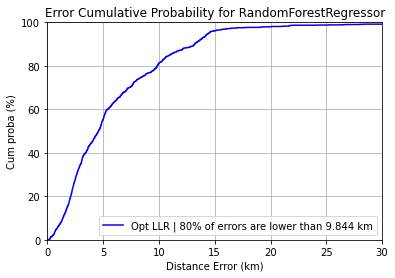

fit complete
predict complete


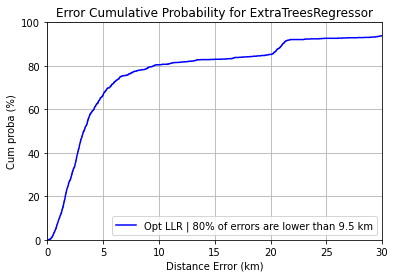

fit complete
predict complete


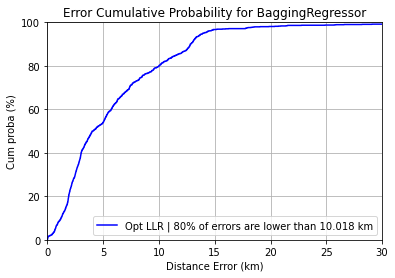

impossible to set n_jobs=-1 for GradientBoostingRegressor()
Process could not complete for  GradientBoostingRegressor
impossible to set n_jobs=-1 for AdaBoostRegressor()
Process could not complete for  AdaBoostRegressor
Process could not complete for  VotingClassifier
Process could not complete for  VotingRegressor
Process could not complete for  StackingClassifier
Process could not complete for  StackingRegressor
impossible to set n_jobs=-1 for ARDRegression()
Process could not complete for  ARDRegression
impossible to set n_jobs=-1 for BayesianRidge()
Process could not complete for  BayesianRidge
impossible to set n_jobs=-1 for ElasticNet()
fit complete
predict complete


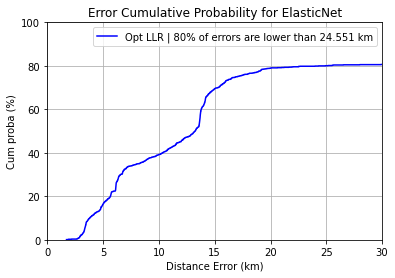

Process could not complete for  ElasticNetCV
Process could not complete for  Huber
impossible to set n_jobs=-1 for HuberRegressor()
Process could not complete for  HuberRegressor
impossible to set n_jobs=-1 for Lars()
fit complete
predict complete


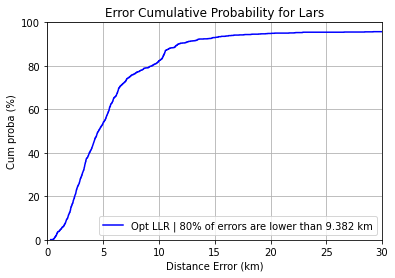

Process could not complete for  LarsCV
impossible to set n_jobs=-1 for Lasso()
fit complete
predict complete


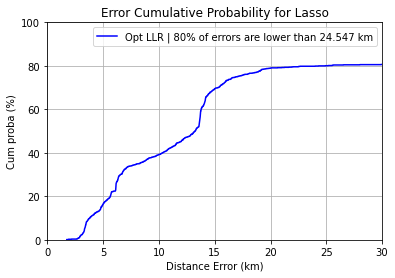

Process could not complete for  LassoCV
impossible to set n_jobs=-1 for LassoLars()
fit complete
predict complete


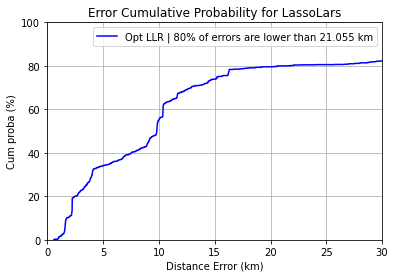

Process could not complete for  LassoLarsCV
impossible to set n_jobs=-1 for LassoLarsIC()
Process could not complete for  LassoLarsIC
fit complete
predict complete


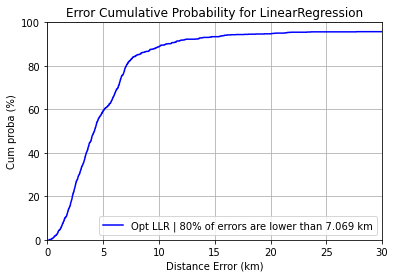

impossible to set n_jobs=-1 for MultiTaskElasticNet()
fit complete
predict complete


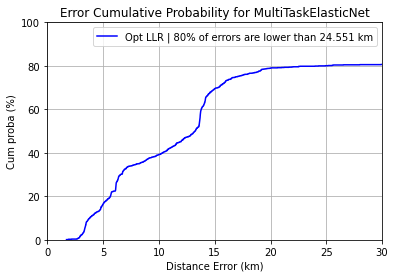

fit complete
predict complete


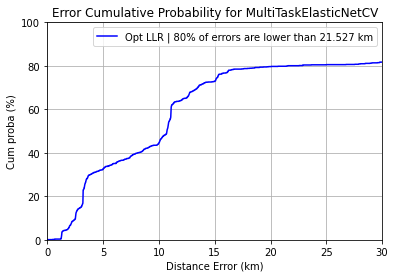

impossible to set n_jobs=-1 for MultiTaskLasso()
fit complete
predict complete


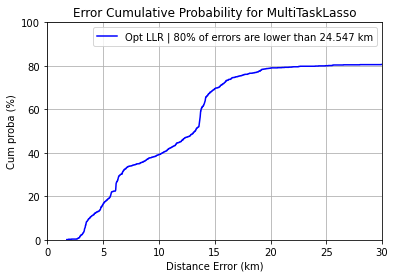

fit complete
predict complete


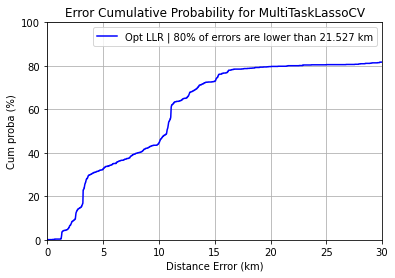

impossible to set n_jobs=-1 for OrthogonalMatchingPursuit()
fit complete
predict complete


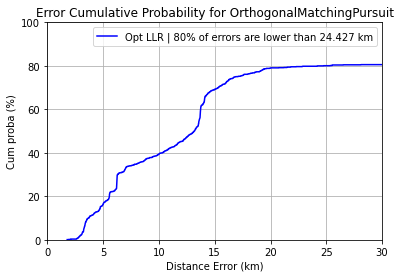

Process could not complete for  OrthogonalMatchingPursuitCV
impossible to set n_jobs=-1 for PassiveAggressiveRegressor()
Process could not complete for  PassiveAggressiveRegressor
impossible to set n_jobs=-1 for Ridge()
fit complete
predict complete


C:\Users\julie\.conda\envs\Julien\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.77739e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


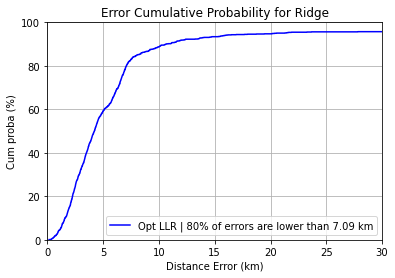

impossible to set n_jobs=-1 for RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
fit complete
predict complete
Process could not complete for  RidgeCV
impossible to set n_jobs=-1 for SGDRegressor()
Process could not complete for  SGDRegressor
Process could not complete for  TheilSenRegressor
Process could not complete for  enet_path
Process could not complete for  lars_path
Process could not complete for  lars_path_gram
Process could not complete for  lasso_path
Process could not complete for  orthogonal_mp
Process could not complete for  orthogonal_mp_gram
Process could not complete for  ridge_regression
impossible to set n_jobs=-1 for RANSACRegressor()
fit complete
predict complete


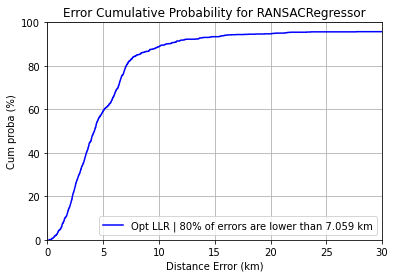

impossible to set n_jobs=-1 for PoissonRegressor()
Process could not complete for  PoissonRegressor
impossible to set n_jobs=-1 for GammaRegressor()
Process could not complete for  GammaRegressor
impossible to set n_jobs=-1 for TweedieRegressor()
Process could not complete for  TweedieRegressor
Process could not complete for  BaseDecisionTree
impossible to set n_jobs=-1 for DecisionTreeRegressor()
fit complete
predict complete


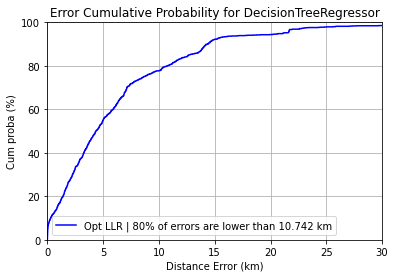

impossible to set n_jobs=-1 for ExtraTreeRegressor()
fit complete
predict complete


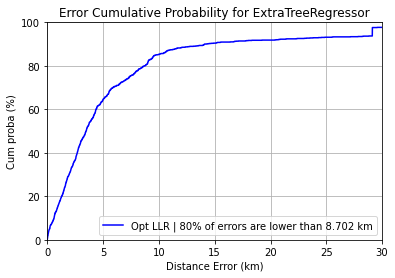

Process could not complete for  export_graphviz
Process could not complete for  plot_tree
Process could not complete for  export_text
impossible to set n_jobs=-1 for LinearSVR()
Process could not complete for  LinearSVR
impossible to set n_jobs=-1 for NuSVR()
Process could not complete for  NuSVR
impossible to set n_jobs=-1 for SVR()
Process could not complete for  SVR
Process could not complete for  l1_min_c
Process could not complete for  BallTree
Process could not complete for  DistanceMetric
Process could not complete for  KDTree
fit complete
predict complete


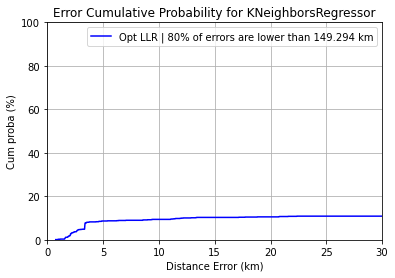

fit complete
predict complete


C:\Users\julie\.conda\envs\Julien\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Process could not complete for  RadiusNeighborsRegressor
Process could not complete for  kneighbors_graph
Process could not complete for  radius_neighbors_graph
Process could not complete for  VALID_METRICS
Process could not complete for  VALID_METRICS_SPARSE
impossible to set n_jobs=-1 for GaussianProcessRegressor()
Process could not complete for  GaussianProcessRegressor
Process could not complete for  kernels
Process could not complete for  SelfTrainingClassifier
impossible to set n_jobs=-1 for PLSCanonical()
fit complete
predict complete


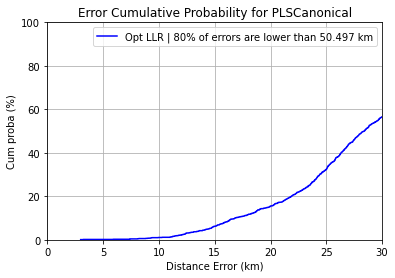

impossible to set n_jobs=-1 for PLSRegression()
fit complete
predict complete


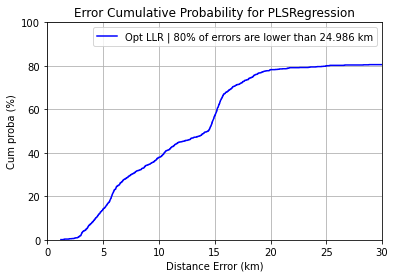

impossible to set n_jobs=-1 for CCA()
fit complete
predict complete


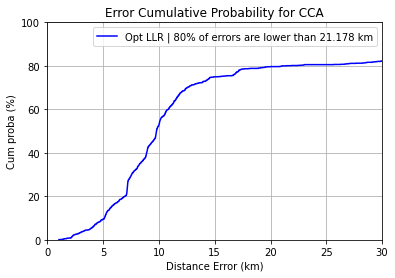

Process could not complete for  MultiOutputRegressor
Process could not complete for  MultiOutputClassifier
Process could not complete for  ClassifierChain
Process could not complete for  RegressorChain
Process could not complete for  check_increasing
Process could not complete for  isotonic_regression
impossible to set n_jobs=-1 for IsotonicRegression()
Process could not complete for  IsotonicRegression
tester l'algorithme a pris 40.139 secondes


In [40]:
a = time.time()
# scores_sans_feat_augmentation = testingalgos(xtrain,ytrain,xtest,ytest)

scores_sans_feat_augmentation = testingalgos(xtrain_pa,ytrain_pa,xtest_pa,ytest_pa,messidtest_pa)
b = time.time()
print(f"tester l'algorithme a pris {round(b-a,3)} secondes")

## Synthèse des résultats du train sans Feature Augmentation <a class="anchor" id="data_basique_summary"></a>

In [41]:
print(f"Tester les algorithmes sur le dataset non-augmenté a pris {round(b-a,3)} secondes")
print("Ci-dessous les Distances Errors de différents modèles entrainés et testés sans fine-tune")
scores_sans_feat_augmentation

Tester les algorithmes sur le dataset non-augmenté a pris 40.139 secondes
Ci-dessous les Distances Errors de différents modèles entrainés et testés sans fine-tune


,Model,DistError
0,RandomForestRegressor,9.843980
1,ExtraTreesRegressor,9.500479
2,BaggingRegressor,10.018489
3,ElasticNet,24.550931
4,Lars,9.382214
5,Lasso,24.546921
6,LassoLars,21.054737
7,LinearRegression,7.068885
8,MultiTaskElasticNet,24.550894
9,MultiTaskElasticNetCV,21.527400


# Partie III: Avec de la Feature Augmentation  <a class="anchor" id="data_aug"></a>

## Génération du dataset <a class="anchor" id="data_aug_generation"></a>

In [24]:
a = time.time()

#create the train and test features matrix with above functions
x_train_withFA, y_train_withFA, messidtrain_withFA = create_x_y_train(pos_train_w_message_number,create_x_train(xtrain,-125))
x_test_withFA, y_test_withFA, messidtest_withFA = create_x_y_train(pos_train_w_message_number,create_x_train(xtest,-115))

b = time.time()

print(f"Process took {round(b-a,3)} seconds to complete")

Process took 7222.03 seconds to complete


#### La création des dataframes avec feature augmentation prend environ 2 heures
La cellule du dessous permettait de sauver les dataframes générés en pickle

In [44]:
# import pickle as pkl
# #Création de dump à partir des features enrichies

# pickle.dump(x_train, open('x_trainJM','wb'))
# pickle.dump(y_train, open('y_trainJM','wb'))
# pickle.dump(x_test, open('x_testJM','wb'))
# pickle.dump(y_test, open('y_testJM','wb'))
# pickle.dump(messidtrain, open('messidtrainJM','wb'))
# pickle.dump(messidtest, open('messidtestJM','wb'))


# # Ouverture des dump générés

# file = open("x_train",'rb')
# x_trainRG = pkl.load(file)

# file = open("x_test",'rb')
# x_testRG = pkl.load(file)

# file = open("y_train",'rb')
# y_trainRG = pkl.load(file)

# file = open("y_test",'rb')
# y_testRG = pkl.load(file)

# file = open("messidtrain",'rb')
# messidtrainRG = pkl.load(file)

# file = open("messidtest",'rb')
# messidtestRG = pkl.load(file)




# file = open("x_trainJM",'rb')
# x_trainJM_expimp = pkl.load(file)

# file = open("x_testJM",'rb')
# x_testJM_expimp = pkl.load(file)

# file = open("y_trainJM",'rb')
# y_trainJM_expimp = pkl.load(file)

# file = open("y_testJM",'rb')
# y_testJM_expimp = pkl.load(file)




### Confirmation qu'il n'y a pas de doublons entre messages id dans le train set et messages id dans le test set

In [25]:
s1=0
s2=0
un=np.unique(messidtrain_withFA)   # messages uniques dans messidtrain
two=np.unique(messidtest_withFA)   # messages uniques dans messidtest
for item in two:
    if item in un:          # pour chaque message dans messidtest, on regarde s'il existe dans messidtrain   
        s1+=1               # s'il existe (doublon entre test et train), s1 = s1 + 1   
    else:
        s2+=1               # s'il n'existe pas (absence de doublon), s2 = s2 + 1
print(f"Nombre de messages id doublons entre train et test: {s1}")
print(f"Nombre de messages id dans test qui ne sont pas dans train: {s2}")

Nombre de messages id doublons entre train et test: 0
Nombre de messages id dans test qui ne sont pas dans train: 1214


## Testing des algorithmes <a class="anchor" id="data_aug_test"></a>

##### NB: Le testing des algorithmes prend un peu moins de 3 heures

Process could not complete for  BaseEnsemble
fit complete
predict complete


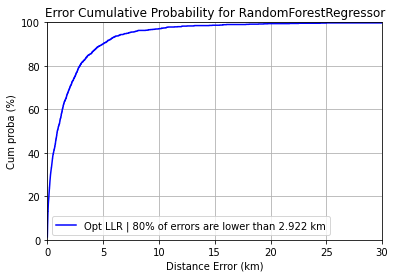

fit complete
predict complete


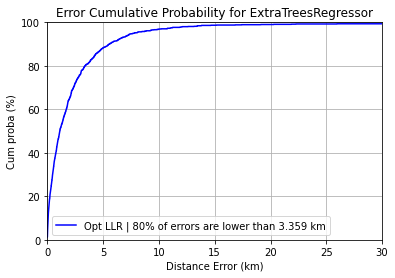

fit complete
predict complete


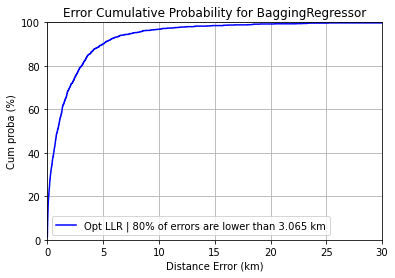

impossible to set n_jobs=-1 for GradientBoostingRegressor()
Process could not complete for  GradientBoostingRegressor
impossible to set n_jobs=-1 for AdaBoostRegressor()
Process could not complete for  AdaBoostRegressor
Process could not complete for  VotingClassifier
Process could not complete for  VotingRegressor
Process could not complete for  StackingClassifier
Process could not complete for  StackingRegressor
impossible to set n_jobs=-1 for ARDRegression()
Process could not complete for  ARDRegression
impossible to set n_jobs=-1 for BayesianRidge()
Process could not complete for  BayesianRidge
impossible to set n_jobs=-1 for ElasticNet()
fit complete
predict complete


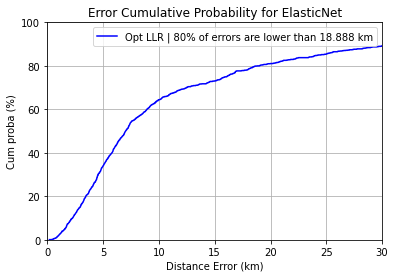

Process could not complete for  ElasticNetCV
Process could not complete for  Huber
impossible to set n_jobs=-1 for HuberRegressor()
Process could not complete for  HuberRegressor
impossible to set n_jobs=-1 for Lars()


C:\Users\julie\.conda\envs\Julien\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.510e-06, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\julie\.conda\envs\Julien\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.255e-06, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\julie\.conda\envs\Julien\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 ite

fit complete
predict complete


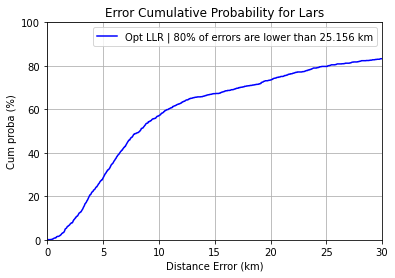

Process could not complete for  LarsCV
impossible to set n_jobs=-1 for Lasso()
fit complete
predict complete


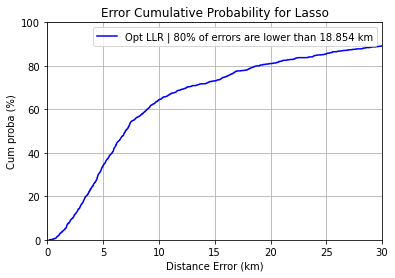

Process could not complete for  LassoCV
impossible to set n_jobs=-1 for LassoLars()
fit complete
predict complete


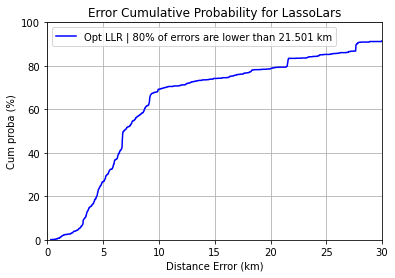

Process could not complete for  LassoLarsCV
impossible to set n_jobs=-1 for LassoLarsIC()
Process could not complete for  LassoLarsIC
fit complete
predict complete


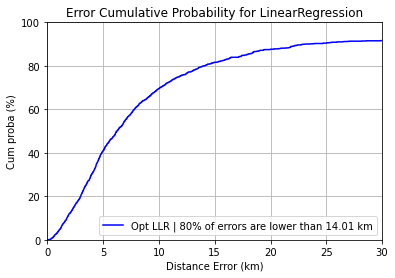

impossible to set n_jobs=-1 for MultiTaskElasticNet()
fit complete
predict complete


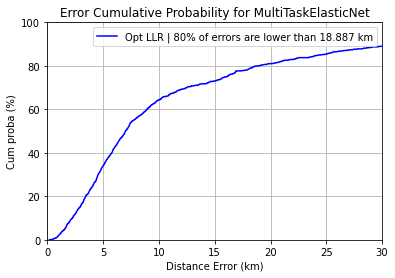

fit complete
predict complete


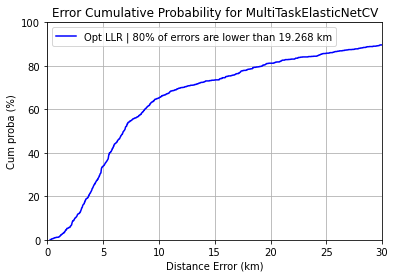

impossible to set n_jobs=-1 for MultiTaskLasso()
fit complete
predict complete


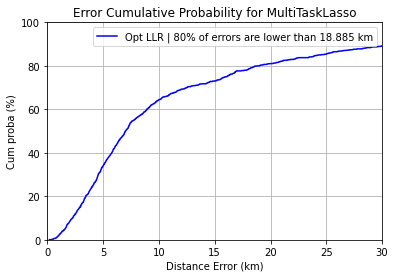

fit complete
predict complete


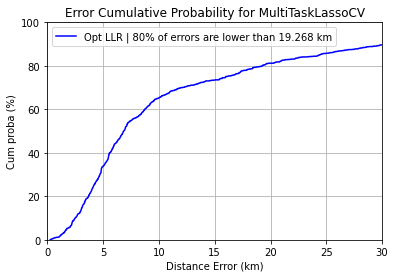

impossible to set n_jobs=-1 for OrthogonalMatchingPursuit()
fit complete
predict complete


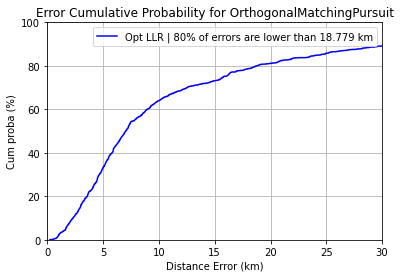

Process could not complete for  OrthogonalMatchingPursuitCV
impossible to set n_jobs=-1 for PassiveAggressiveRegressor()
Process could not complete for  PassiveAggressiveRegressor
impossible to set n_jobs=-1 for Ridge()
fit complete
predict complete


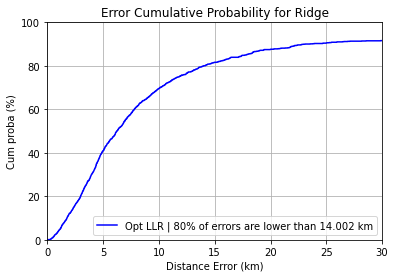

impossible to set n_jobs=-1 for RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
fit complete
predict complete
Process could not complete for  RidgeCV
impossible to set n_jobs=-1 for SGDRegressor()
Process could not complete for  SGDRegressor
Process could not complete for  TheilSenRegressor
Process could not complete for  enet_path
Process could not complete for  lars_path
Process could not complete for  lars_path_gram
Process could not complete for  lasso_path
Process could not complete for  orthogonal_mp
Process could not complete for  orthogonal_mp_gram
Process could not complete for  ridge_regression
impossible to set n_jobs=-1 for RANSACRegressor()
fit complete
predict complete


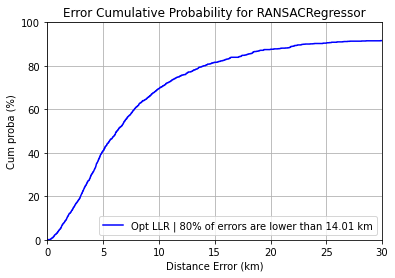

impossible to set n_jobs=-1 for PoissonRegressor()
Process could not complete for  PoissonRegressor
impossible to set n_jobs=-1 for GammaRegressor()
Process could not complete for  GammaRegressor
impossible to set n_jobs=-1 for TweedieRegressor()
Process could not complete for  TweedieRegressor
Process could not complete for  BaseDecisionTree
impossible to set n_jobs=-1 for DecisionTreeRegressor()
fit complete
predict complete


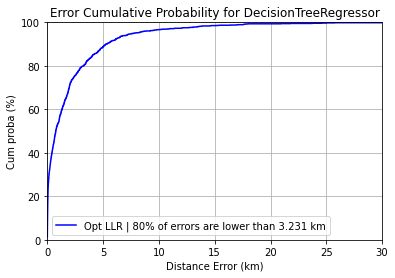

impossible to set n_jobs=-1 for ExtraTreeRegressor()
fit complete
predict complete


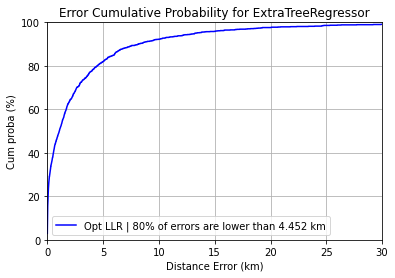

Process could not complete for  export_graphviz
Process could not complete for  plot_tree
Process could not complete for  export_text
impossible to set n_jobs=-1 for LinearSVR()
Process could not complete for  LinearSVR
impossible to set n_jobs=-1 for NuSVR()
Process could not complete for  NuSVR
impossible to set n_jobs=-1 for SVR()
Process could not complete for  SVR
Process could not complete for  l1_min_c
Process could not complete for  BallTree
Process could not complete for  DistanceMetric
Process could not complete for  KDTree
fit complete
predict complete


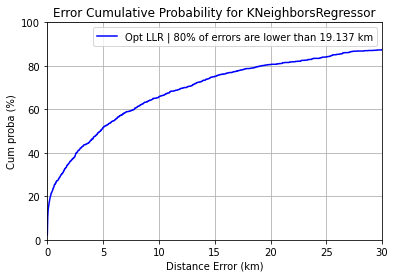

fit complete


C:\Users\julie\.conda\envs\Julien\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


predict complete
Process could not complete for  RadiusNeighborsRegressor
Process could not complete for  kneighbors_graph
Process could not complete for  radius_neighbors_graph
Process could not complete for  VALID_METRICS
Process could not complete for  VALID_METRICS_SPARSE
impossible to set n_jobs=-1 for GaussianProcessRegressor()
Process could not complete for  GaussianProcessRegressor
Process could not complete for  kernels
Process could not complete for  SelfTrainingClassifier
impossible to set n_jobs=-1 for PLSCanonical()
fit complete
predict complete


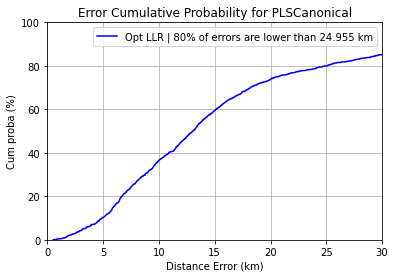

impossible to set n_jobs=-1 for PLSRegression()
fit complete
predict complete


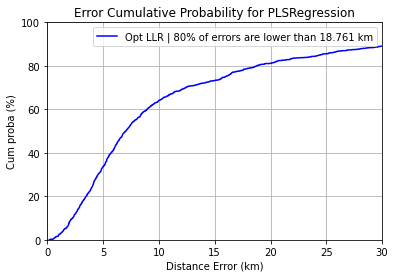

impossible to set n_jobs=-1 for CCA()
fit complete
predict complete


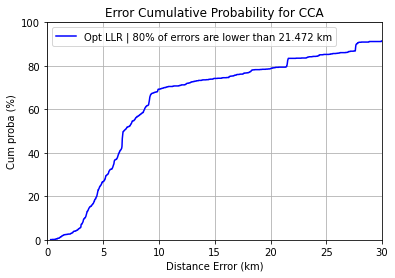

Process could not complete for  MultiOutputRegressor
Process could not complete for  MultiOutputClassifier
Process could not complete for  ClassifierChain
Process could not complete for  RegressorChain
Process could not complete for  check_increasing
Process could not complete for  isotonic_regression
impossible to set n_jobs=-1 for IsotonicRegression()
Process could not complete for  IsotonicRegression


In [26]:
import time

c = time.time()
scores_avec_feat_augmentation = testingalgos(x_train_withFA,y_train_withFA,x_test_withFA,y_test_withFA,messidtest_withFA)
d = time.time()


## Synthèse des résultats <a class="anchor" id="data_aug_summary"></a>


In [27]:
print(f"Testing of different algorithms on enriched featured dataset took {round(d-c,3)} seconds to complete")

Testing of different algorithms on enriched featured dataset took 9953.239 seconds to complete


In [28]:
scores_avec_feat_augmentation

,Model,DistError
0,RandomForestRegressor,2.922219
1,ExtraTreesRegressor,3.358634
2,BaggingRegressor,3.065086
3,ElasticNet,18.887761
4,Lars,25.156102
5,Lasso,18.853544
6,LassoLars,21.501307
7,LinearRegression,14.009565
8,MultiTaskElasticNet,18.887010
9,MultiTaskElasticNetCV,19.267507


# Partie IV: Comparaison Training Data Initial VS Training Data Augmenté
<a class="anchor" id="comparatiffinal"></a>

Dans cette partie, on créé un dataframe avec 3 colonnes: 
    
- Model name
- Distance d'erreur sans feature augmentation
- Distance d'erreur avec feature augmentation
    
Puis on fait un barplot pour établir les comparaisons et voir l'effet du feature Augmentation

## Comparaison en chiffres <a class="anchor" id="comp_chiffres"></a>

In [42]:
DistErrors = scores_sans_feat_augmentation.merge(scores_avec_feat_augmentation,left_on='Model',right_on='Model')
DistErrors.columns = ['Model','DistError_NoFeatAug','DistError_FeatAug']
DistErrors

,Model,DistError_NoFeatAug,DistError_FeatAug
0,RandomForestRegressor,9.843980,2.922219
1,ExtraTreesRegressor,9.500479,3.358634
2,BaggingRegressor,10.018489,3.065086
3,ElasticNet,24.550931,18.887761
4,Lars,9.382214,25.156102
5,Lasso,24.546921,18.853544
6,LassoLars,21.054737,21.501307
7,LinearRegression,7.068885,14.009565
8,MultiTaskElasticNet,24.550894,18.887010
9,MultiTaskElasticNetCV,21.527400,19.267507


## Comparaison graphique <a class="anchor" id="comp_graph"></a>

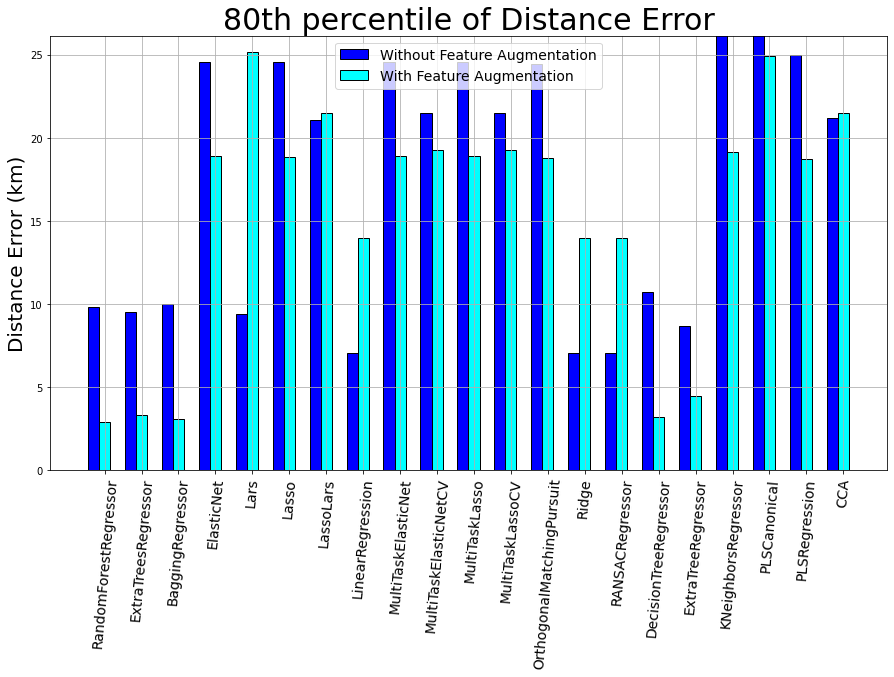

In [78]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
    
    
plt.figure(figsize=(15,8))


# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = DistErrors['DistError_NoFeatAug']#.apply(np.log)

# Choose the height of the cyan bars
bars2 = DistErrors['DistError_FeatAug']#.apply(np.log) 

 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Without Feature Augmentation')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', capsize=7, label='With Feature Augmentation')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], DistErrors['Model'],rotation=85,size=14)
plt.ylabel('Distance Error (km)',size=20)
plt.ylim((0,max(bars2)+1))
plt.grid()

plt.title("80th percentile of Distance Error",size=30)

plt.legend(prop={'size': 14},loc='upper center')
 
plt.show()

# Partie V: Conclusions <a class="anchor" id="conclusion"></a>

Le meilleur score aura été obtenu avec un RandomForestRegressor avec une 80% des objets localisés à moins de 2.92 km
Ces résultats ont été obtenus avec un training set sur lequel on a fait du feature engineering

### Feature Engineering

- Le graphique ci-dessus montre que le Feature Engineering est la clef pour améliorer la qualité de prédiction.
Le fait d'ajouter artificiellement des lignes utilisant les base station ayant le mieux capté les messages aide à réduire le biais.

En effet, nous avions à la base une erreur "structurelle" d'estimation d'emplacement d'objet. Cela correspond donc à un problème de biais.

En ajoutant des features, nous avons augmenté le pouvoir explicatif du modèle et réduit le biais. Ce qui se traduit par le fait que la distance d'erreur correspondant au 80ème percentile a diminué.



- Le fait d'utiliser les bases stations donnant les réponses les plus fortes va régler le problème des bases localisées au Canada qui renvoient des signaux très faibles de très loin


### Algorithmes

- Le meilleur résultat est donné par le RandomForestRegressor.


- De manière générale, les algorithmes ensemblistes sont très bien classés et donnent parmis les meilleurs résultats (ExtraTreeRegressor / ExtraTreesRegressor / RandomForestRegressor / BaggingRegressor)


Il est important de signaler qu'aucun tuning n'a été fait sur les paramètres de calcul. Le seul ayant été n_jobs=-1 afin d'utiliser tous les processeurs quand l'option existe. 

Cela met en exergue que ce problème est un problème de feature engineering avant d'être un problème de choix d'algorithme. 

On montre dans la section suivante qu'un algorithme plus complexe (MLP fine-tuné) marchent moins bien que les algorithmes ensemblistes.




# Partie VI (pour le fun...) : Tentative de réseau de neurones <a class="anchor" id="funNN"></a>

Dans cette section, nous avons essayé un réseau de neurones et souhaitons montrer qu'il n'est pas optimal pour minimiser l'erreur de prédiction de l'emplacement de l'objet. 

- Le réseau de neurones aura été tenté avec et sans normalisation des inputs. 

- La Loss retenue est (sans surprise) une MSE

- Les optimiseurs testés sont la SGD et Adam. Les deux marchent bien, mais Adam converge (sans surprise) plus rapidement. 

- Au vu de la complexité du problème proposé, il n'est pas utile d'utiliser beaucoup de neurones. Une couche cachée suffit. En ajouter complexifie inutilement le calcul et augmente la distance du 80ème percentile.

In [45]:
# On change le type des inputs pour les rendre Keras-compatibles

Xtrain = x_train_withFA.astype(np.float32)
Ytrain = y_train_withFA.astype(np.float32)
Xtest =  x_test_withFA.astype(np.float32)
Ytest = y_test_withFA.astype(np.float32)

In [59]:
Xtrain.shape,Xtest.shape,Ytrain.shape,Ytest.shape

((1730486, 24), (89700, 24), (1730486, 2), (89700, 2))

In [71]:
from tensorflow import keras

# Définition de l'architecture du réseau


model = keras.Sequential(
    [
        keras.layers.Dense(48,activation="sigmoid", input_shape=(Xtrain.shape[-1],)),
        keras.layers.Dense(units=Ytrain.shape[-1], activation="linear"),           

    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 98        
Total params: 1,298
Trainable params: 1,298
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Définition des hyperparamètres

# Définition d'une Loss MSE pour ce problème de régression
loss_mse = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

# Optimiseur: On choisit un optimiseur de type Adam avec les paramètres de Decay et Momentum par défaut. 
model.compile(optimizer=keras.optimizers.Adam(5e-2), loss=loss_mse)

# # Conditions d'arrêt du réseau de neurones avant la fin du nombre d'epochs
my_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_loss",      # il vérifie la loss de validation
    min_delta=0,             # différence minimale de loss validation entre 2 itérations
    patience=10,              # si la loss remonte 3 itérations de suite, le NN s'arrête 
    verbose=0,               # quantité de commentaires donnés par keras pendant le process
    mode="auto",
    baseline=None,                 
    restore_best_weights=True)  # S'il a trop itéré et dépassé le val_loss optimal, il restore les poids correspondant
                                # à la val_loss optimale


model.fit(
    Xtrain,                               
    Ytrain,                                
    batch_size=100000,                    # Nombre de samples par batch
    epochs=500,                           # 500 itérations au maximum 
    verbose=2,                            # Quantité d'infos données lors du process
    callbacks=[my_callbacks],             # Définition des early stoppings définis au dessus
    validation_data=(Xtest, Ytest),       # Définition des validation data pour savoir si NN continue ou s'arrête
    )


Epoch 1/500
18/18 - 1s - loss: 4944.1299 - val_loss: 3702.4456
Epoch 2/500
18/18 - 1s - loss: 2927.1799 - val_loss: 2140.6118
Epoch 3/500
18/18 - 1s - loss: 1672.7089 - val_loss: 1198.9318
Epoch 4/500
18/18 - 1s - loss: 914.8996 - val_loss: 628.9212
Epoch 5/500
18/18 - 1s - loss: 463.8773 - val_loss: 302.9715
Epoch 6/500
18/18 - 1s - loss: 215.7799 - val_loss: 133.5893
Epoch 7/500
18/18 - 1s - loss: 91.6665 - val_loss: 53.5376
Epoch 8/500
18/18 - 1s - loss: 35.3092 - val_loss: 19.3799
Epoch 9/500
18/18 - 1s - loss: 12.2527 - val_loss: 6.2981
Epoch 10/500
18/18 - 1s - loss: 3.8010 - val_loss: 1.8262
Epoch 11/500
18/18 - 1s - loss: 1.0443 - val_loss: 0.4712
Epoch 12/500
18/18 - 1s - loss: 0.2516 - val_loss: 0.1105
Epoch 13/500
18/18 - 1s - loss: 0.0534 - val_loss: 0.0270
Epoch 14/500
18/18 - 1s - loss: 0.0111 - val_loss: 0.0103
Epoch 15/500
18/18 - 1s - loss: 0.0037 - val_loss: 0.0073
Epoch 16/500
18/18 - 1s - loss: 0.0027 - val_loss: 0.0068
Epoch 17/500
18/18 - 1s - loss: 0.0026 - val_l

In [73]:
# On fait les prédictions avec le modèle appris par le NN.
pred = model.predict(Xtest)

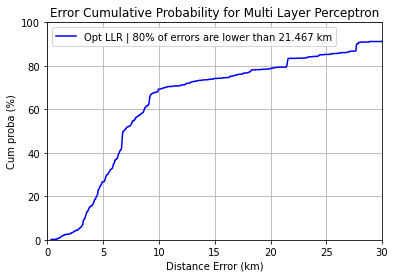

In [74]:
unique_mess_id_test=np.unique(messidtest_withFA)
pred2=np.zeros((len(unique_mess_id_test),2))
y2=np.zeros((len(unique_mess_id_test),2))
counter=0
for mess in unique_mess_id_test:
    nb_val=0
    avg_pos=np.array([0.0,0.0])
    for row in range(len(pred)):
        if messidtest_withFA[row]==mess:
            ytmp=Ytest[row]
            avg_pos+=pred[row]*np.max(Xtest[row,-3:])
            nb_val+=np.max(Xtest[row,-3:])
    avg_pos/=nb_val
    pred2[counter]=avg_pos
    y2[counter]=ytmp
    counter+=1


err_vec=Eval_geoloc(y2[:,0] , y2[:,1], pred2[:,0], pred2[:,1])

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title(f'Error Cumulative Probability for Multi Layer Perceptron'); 
plt.legend( [f"Opt LLR | 80% of errors are lower than {round(np.percentile(err_vec, 80),3)} km", "LLR 95", "LLR 99"])
plt.show()

Donc, le réseau de neurones ne permet pas d'améliorer la qualité de localisation. Et reste moins performant qu'un arbre de décision. 